# [Time travel](https://github.com/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb)

## Review

We discussed motivations for `human-in-the-loop`:

(1) **Approval** - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) **Debugging** - We can rewind the graph to reproduce or avoid issues

(3) **Editing** - You can modify the state

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph supports debugging by viewing, re-playing, and even forking from past states.

We call this time travel.

In [13]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

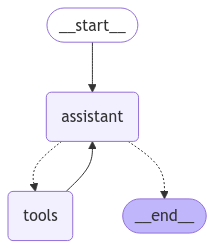

In [14]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [15]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_12DvcgoHAJik6GlpUdNlpzDM)
 Call ID: call_12DvcgoHAJik6GlpUdNlpzDM
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

We can use `get_state` to look at the current state of our graph, given the thread_id!

In [16]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f146e616-eac1-4a25-b256-aafc6c6ec164-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.

In [17]:
all_states = [s for s in graph.get_state_history(thread)]

In [18]:
len(all_states)

5

In [29]:
for s in range(len(all_states)):
    print(f"{s}\n{[value for value in all_states[s].values['messages']]}")

0
[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f146e616-eac1-4a25-b256-aafc6c6ec164-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 18, 'total_

The first element is the current state, just as we got from `get_state`.

In [41]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f146e616-eac1-4a25-b256-aafc6c6ec164-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

Everything above we can visualize here:

![image](breakpoints.png)|

We can re-run our agent from any of the prior steps.

[![image](replaying.png)]

Let's look back at the step that recieved human input!

In [42]:
to_replay = all_states[-2]

In [43]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd0b64-dddf-6889-8000-32de3364acc9'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-01-12T07:24:48.079244+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd0b64-ddda-6c97-bfff-afced4ea565c'}}, tasks=(PregelTask(id='773a3f65-923b-dfca-dca9-9790407820f1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_12DvcgoHAJik6GlpUdNlpzDM', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

Look at the state.

In [44]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]}

We can see the next node to call.

In [45]:
to_replay.next

('assistant',)

We also get the `config`, which tells us the `checkpoint_id` as well as the `thread_id`.

In [46]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0b64-dddf-6889-8000-32de3364acc9'}}

To replay from here, we simply pass the `config` back to the agent!

The graph knows that this checkpoint has aleady been executed.

It just re-plays from this checkpoint!

In [47]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7Ftp53WpihRL6O8xaAg72kl6)
 Call ID: call_7Ftp53WpihRL6O8xaAg72kl6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![image](forking.png)

In [48]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]

Again, we have the config.

In [49]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0b64-dddf-6889-8000-32de3364acc9'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied.

Remember how our reducer on messages works:

+ It will append, unless we supply a message ID.
+ We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [50]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [51]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd0b9b-661c-6762-8001-747f5dab4423'}}

This creates a new, forked checkpoint.

But, the metadata - e.g., where to go next - is perserved!

We can see the current state of our agent has been updated with our fork.

In [52]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]

In [53]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd0b9b-661c-6762-8001-747f5dab4423'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd0b64-dddf-6889-8000-32de3364acc9'}, created_at='2025-01-12T07:49:11.916254+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd0b64-dddf-6889-8000-32de3364acc9'}}, tasks=(PregelTask(id='25fb4e91-5a39-b3e8-cbec-fa766e27a2b6', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [54]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZLWhT6qxkylbgpddJRXXG5RL)
 Call ID: call_ZLWhT6qxkylbgpddJRXXG5RL
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [55]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='0579d339-b217-42f6-bae8-a44e1d1e903c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZLWhT6qxkylbgpddJRXXG5RL', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-758d991d-d44c-46c4-a075-6eba40533d4f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_ZLWhT6qxkylbgpddJRXXG5RL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1